# Nregions Inference
#### Following on from Multifrequency code and Anstey FG regions Model, we are now interested in bringing it all together to infer the 21-cm foregrounds using the Anstey model.

In [20]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

In [3]:
# Forward model the fiducial degraded GSMA.
Nfreq = 51
nuarr = np.linspace(50,100,Nfreq)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=(-1000,80,5))

times = np.linspace(0,24,24, endpoint=False)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_multifreq(nuarr, nside, lmax, Ntau=len(times), times=times, beam_use=narrow_cosbeam, return_mat=True)

d = mat_A@(fg_alm+cm21_alm)
dnoisy, noise_covar = SM.add_noise(temps=d, dnu=1, Ntau=npix, t_int=1e4)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561


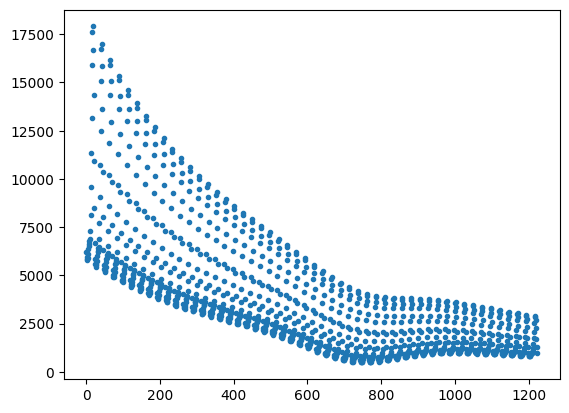

In [4]:
plt.plot(dnoisy.vector, '.')
plt.show()

In [6]:
#4 region inference.
import nregions_inference as NRI
mask_maps, inference_bounds = NRI.mask_split(Nregions=4)
mod = FM.genopt_nregions_cm21_pl_forward_model(nuarr, mask_maps, mat_A, mat_Y)

In [28]:
len(priors)

10

In [29]:

# create a small ball around the MLE the initialize each walker
nwalkers, fg_dim, cm21_dim = 32, len(inference_bounds), 3
ndim = fg_dim + cm21_dim

theta_guess = [0.5*(bound[0]+bound[1]) for bound in inference_bounds] + [-1000, 80, 5]
theta_guess = np.array(theta_guess)
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))

priors = [[-0.1, 5.0]]*fg_dim
priors += [[-1500, -500], [70, 90], [1, 10]]
priors = np.array(priors)
NRI.log_posterior(theta=theta_guess, y=dnoisy.vector, yerr=np.sqrt(noise_covar.diag), model=mod, prior_range=priors)

-230146595243.36942

In [31]:

# run emcee
steps = 10000
err = np.sqrt(noise_covar.diag)
sampler = EnsembleSampler(nwalkers, ndim, NRI.log_posterior, 
                    args=(dnoisy.vector, err, mod, priors))
_=sampler.run_mcmc(pos, steps, progress=True)
np.save(f"saves/Nregs_pl_gsmalo_cm21mon/{fg_dim}reg", sampler.get_chain())

100%|██████████| 10000/10000 [06:48<00:00, 24.50it/s]


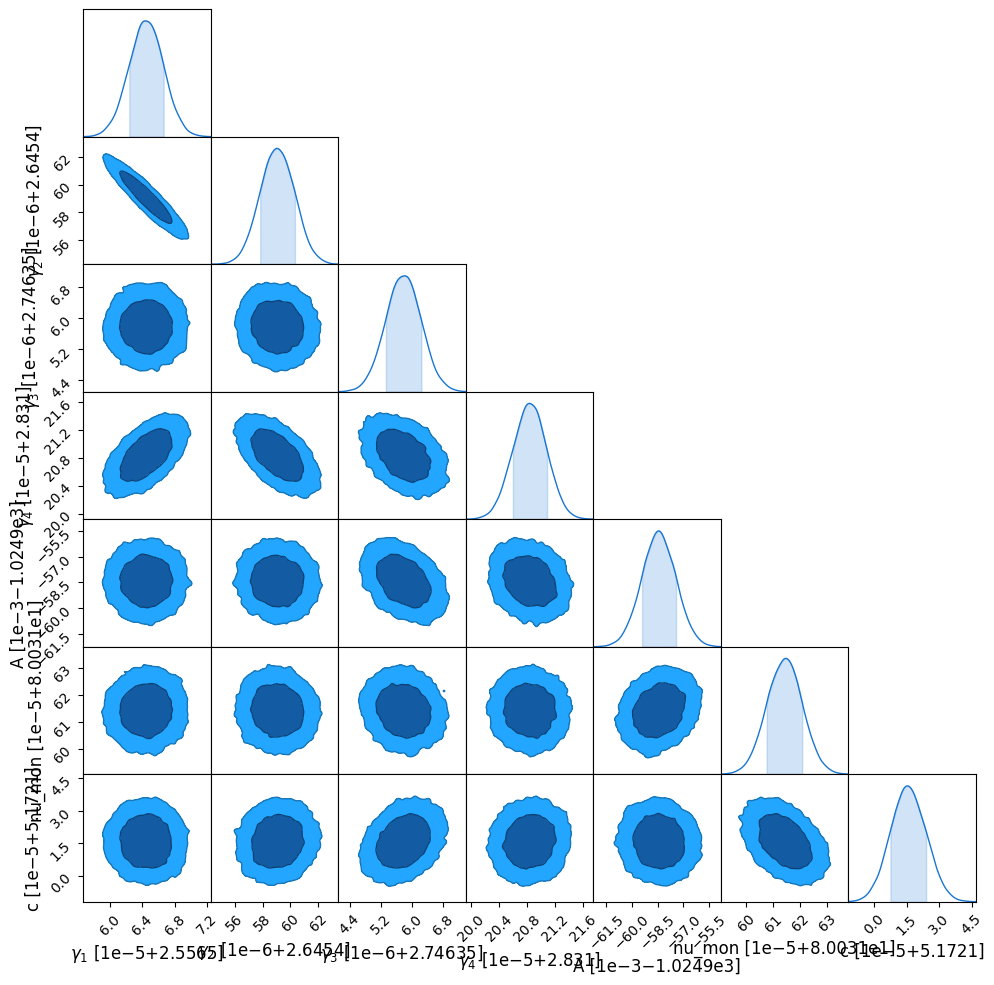

In [41]:
chain = np.load("saves/Nregs_pl_gsmalo_cm21mon/4reg.npy")
c=ChainConsumer()
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$', "A", 'nu_mon', 'c'])
c.plotter.plot(truth=[2, 2, 2, 2, -1000, 80, 5])
plt.show()

In [38]:
theta_guess

array([    2.53775684,     2.68720031,     2.83664378,     2.98608725,
       -1000.        ,    80.        ,     5.        ])

In [39]:
np.mean(chain_clean, axis=0)

array([    2.5565645 ,     2.64545907,     2.74635579,     2.83120836,
       -1024.95842965,    80.0316143 ,     5.17211581])

In [ ]:
array([    2.5565645 ,     2.64545907,     2.74635579,     2.83120836,
       -1024.95842965,    80.0316143 ,     5.17211581])